In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [2]:
Q_EC_71Ge=0.2326 #in MeV
Z_71Ge=32

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 

Be862_en = 0.862 #Mev

S_n = 7.415 #энергия отрыва нейтрона

total_GT = 27*0.65

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [7]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [8]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

E_x до 5 МэВ!!!

In [9]:
BGT=pd.read_excel('../B(GT) peaks processing/recognition/Ga/bgt_table_values/2015_ind_st_bgt_table.xls') #таблица со значениями B(GT)
BGT.head()

,E,BGT
0,0,8.52
1,175,0.34
2,500,1.76
3,708,0.11
4,808,2.29


In [10]:
BGT['BGT'] = BGT['BGT']/100 #делим на 10 т.к. в таблице все значения домножены на 10

#### table B(GT) summ

In [11]:
table_BGT = np.sum(BGT['BGT'].values)
print(table_BGT)

0.2579


## solar neutrino flux

In [12]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [52]:
step_all_fluxes = 0.0001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [53]:
pp_ampl = BS05OP_pp
hep_ampl = BS05OP_hep
B_ampl = BS05OP_B
N_ampl = BS05OP_N
O_ampl = BS05OP_0
F_ampl = BS05OP_F

pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

BS05OP_flux = {
    'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                   fp=pp['Probability'].values * pp_ampl ),
    'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                   fp=b8['Probability'].values * B_ampl ),
    'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                   fp=hep['Probability'].values * hep_ampl ),
    'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                   fp=n13['Probability'].values * N_ampl ),
    'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                   fp=o15['Probability'].values * O_ampl ),
    'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                   fp=f17['Probability'].values * F_ampl ),
}

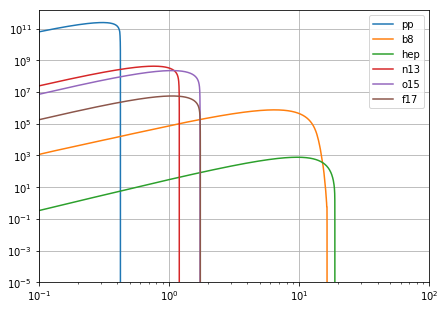

In [54]:
plt.figure(figsize=(7,5))
plt.plot(Energy_all_fluxes, BS05OP_flux['pp'], label='pp')
plt.plot(Energy_all_fluxes, BS05OP_flux['b8'], label='b8')
plt.plot(Energy_all_fluxes, BS05OP_flux['hep'], label='hep')
plt.plot(Energy_all_fluxes, BS05OP_flux['n13'], label='n13')
plt.plot(Energy_all_fluxes, BS05OP_flux['o15'], label='o15')
plt.plot(Energy_all_fluxes, BS05OP_flux['f17'], label='f17')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.1, 100)
plt.grid()
plt.legend()
plt.show()

## solar neutrino best fit flux
based on Table 4 from D. Frekkers PHYSICAL REVIEW C 91, 034608 (2015) 

In [55]:
FluxBestFit_Be = 4.99e9
FluxBestFit_pp = 6.02e10
FluxBestFit_pep = 1.63e8
FluxBestFit_hep = 1.2e4
FluxBestFit_B = 5.39e6
FluxBestFit_CN0 = 2.3e8

In [56]:
pp_ampl = FluxBestFit_pp
hep_ampl = FluxBestFit_hep
B_ampl = FluxBestFit_B

pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')
be384 = pd.read_excel('../Solar_neutrino_flux/be7_384_3.xls')
be861 = pd.read_excel('../Solar_neutrino_flux/be7_861_3.xls')

CNO_flux = np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                     fp=n13['Probability'].values) + \
np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, fp=o15['Probability'].values) +\
np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, fp=f17['Probability'].values)

CNO_flux = CNO_flux / 3 #normalize to 1

be384 = pd.read_excel('../Solar_neutrino_flux/be7_384_3.xls')
be861 = pd.read_excel('../Solar_neutrino_flux/be7_861_3.xls')
be384['Energy'] = (be384['Energy'] + 384.3) / 1000
be861['Energy'] = (be861['Energy'] + 861.3) / 1000
be384['Probability'] = be384['Probability'] * 0.103
be861['Probability'] = be861['Probability'] * 0.897

be_shape = np.interp(x=Energy_all_fluxes, xp=be384['Energy'].values, 
                     fp=be384['Probability'].values) + \
np.interp(x=Energy_all_fluxes, xp=be861['Energy'].values, fp=be861['Probability'].values)
be_shape = be_shape / 2

experim_flux = {
    'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                   fp=pp['Probability'].values * pp_ampl ),
    'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                   fp=b8['Probability'].values * B_ampl ),
    'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                   fp=hep['Probability'].values * hep_ampl ),
    'cno':CNO_flux*FluxBestFit_CN0,
    'be7upd':be_shape*FluxBestFit_Be
}

### Cross-section and total rate

### Расчет сечения с учетом только дискретных уровней 

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [57]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [58]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [59]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, func_Be_ampl = BS05OP_Be):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        print(elem, ' ', rate)
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    print('pep', ' ', rate_pep)
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    print('Be', ' ', rate_Be)
    rate_total+=rate_Be
    
    print('rate_total',' ', rate_total)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

In [60]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_71Ge, Q_EC_71Ge) 
                  for (BGT_k, E_k) in zip(BGT['BGT'].values, BGT['E'].values)]) 
             for E_nu in Energy_all_fluxes]

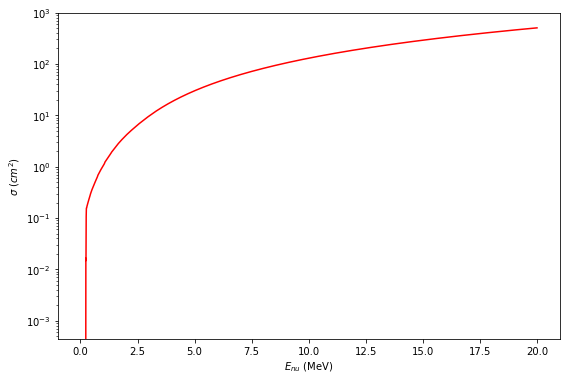

In [48]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.title('Сечение с учетом только дискретных состояний')

In [49]:
rate_calc(sigma_less5, BS05OP_flux, Energy_all_fluxes, step_all_fluxes, 
          BS05OP_pep, BS05OP_Be)

n13   1.9614464223795238
o15   2.764277766523416
f17   0.06968829675807832
b8   3.8071833497664147
pp   71.66092217999638
hep   0.010807236412406749
pep   3.021022268168928
Be   36.9633254393634
rate_total   120.25867295936855


In [ ]:
pp   71.70186838546007
O   2.746388793716662
F   0.06926832437756995
hep   0.010816936213192477
B   3.8071821295324626
N   1.9558561435359982
pep   3.0211094454196235
Be   36.96493021613875
rate_total   120.27742037439432

In [50]:
rate_calc(sigma_less5, experim_flux, Energy_all_fluxes, step_all_fluxes, 
          FluxBestFit_pep, FluxBestFit_Be)

cno   2.3142490287448414
b8   3.606453120428993
pp   72.01982496220002
be7upd   0.018527225734229807
hep   0.016353951695949685
pep   3.4677931669826423
Be   38.108883045955245
rate_total   119.55208450174192


### Расчет сечения с учетом непрерывной части


(0, 4)

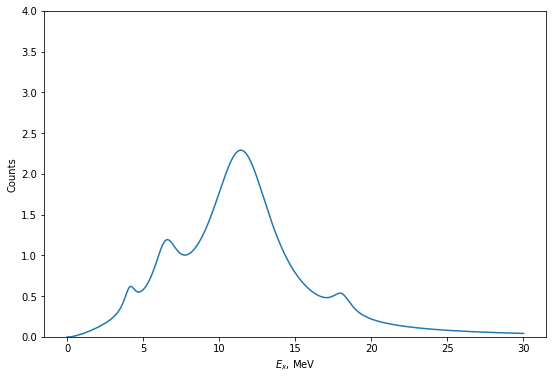

In [28]:
best_fit = pd.read_csv('71Ga_2PR.csv')
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

plt.figure(figsize=(9,6))
plt.plot(best_fit['x'].values, best_fit['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,4)

In [29]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

Text(0.5,0,'Ex')

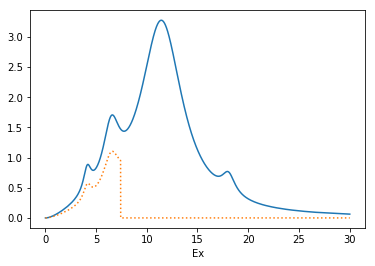

In [33]:
y_17 = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (total_GT-table_BGT)
y_27 = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (27-table_BGT)

#y_best_fit_border = border_func(best_fit['x'].values, y_best_fit, S_n)
y_17_2border = border_func2(best_fit['x'].values, y_17, 3, S_n)
y_27_2border = border_func2(best_fit['x'].values, y_27, 3, S_n)

y_17_border = border_func(best_fit['x'].values, y_17, S_n)
y_27_border = border_func(best_fit['x'].values, y_27, S_n)
#y_best_fit_border5 = border_func(best_fit['x'].values, y_best_fit, 5)


#plt.plot(best_fit['x'].values, y_17)
plt.plot(best_fit['x'].values, y_27)
#plt.plot(best_fit['x'].values, y_best_fit_border, ls='-.')
#plt.plot(best_fit['x'].values, y_17_2border, ls='--')
#plt.plot(best_fit['x'].values, y_27_2border, ls='--')
plt.plot(best_fit['x'].values, y_17_border, ls=':')
plt.xlabel('Ex')

In [34]:
total_GT

17.55

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [35]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [36]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [37]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

### norm 17

In [38]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_17_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_17_border, 200) for p in p_list]

sigma_17_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_71Ge, fp=sigma_17_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

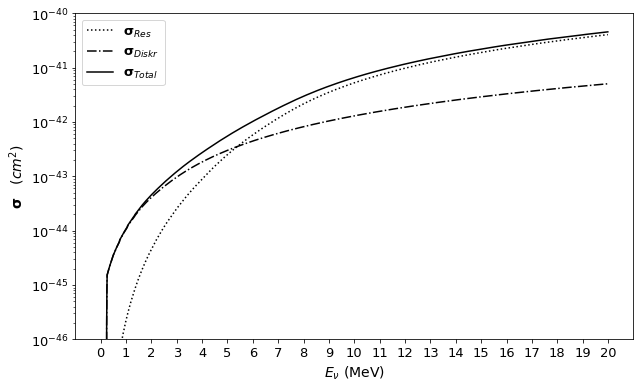

In [39]:
plt.figure(figsize=(10,6))
const = math.pow(10,-44)
plt.plot(Energy_all_fluxes, sigma_17_border_full * const, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, np.array(sigma_less5) * const, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, (np.array(sigma_less5)+sigma_17_border_full) * const, 
         ls='-', c='k', label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-46), 10**(-40))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [40]:
rate_calc(sigma_less5)

pp   71.70186838546007
O   2.746388793716662
F   0.06926832437756995
hep   0.010816936213192477
B   3.8071821295324626
N   1.9558561435359982
pep   3.0211094454196235
rate_total   83.31249015825559


In [41]:
rate_calc(sigma_17_border_full)

pp   0.016214041940230763
O   0.09963741614970509
F   0.0025340962639553806
hep   0.05429813773677347
B   12.011742904303203
N   0.027196168611643562
pep   0.15758334768585996
rate_total   12.369206112691371


In [42]:
rate_calc(sigma_less5+sigma_17_border_full)

pp   71.7180824274003
O   2.8460262098663667
F   0.07180242064152532
hep   0.06511507394996596
B   15.818925033835665
N   1.983052312147642
pep   3.1786927931054834
rate_total   95.68169627094697


### norm 36

In [35]:
p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_36_2border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values, y_36_2border, 200) for p in p_list]

sigma_36_2border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_36_2border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

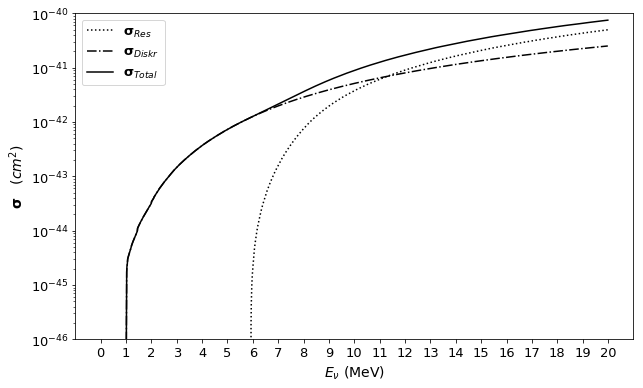

In [36]:
plt.figure(figsize=(10,6))
const = math.pow(10,-44)
plt.plot(Energy_all_fluxes, sigma_36_2border_full * const, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, np.array(sigma_less5) * const, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, (np.array(sigma_less5)+sigma_36_2border_full) * const, 
         ls='-', c='k', label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad (cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-46), 10**(-40))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

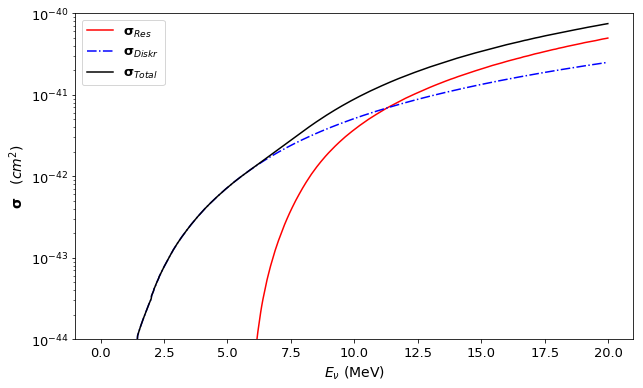

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)

const = math.pow(10,-44)
ax.plot(Energy_all_fluxes, sigma_36_2border_full * const, c='red', 
         label='$\mathbf{\sigma}_{Res}$')
ax.plot(Energy_all_fluxes, np.array(sigma_less5) * const, ls='-.', c='blue', 
         label='$\mathbf{\sigma}_{Diskr} $')
ax.plot(Energy_all_fluxes, (np.array(sigma_less5)+sigma_36_2border_full) * const, 
         ls='-', c='k', label='$\mathbf{\sigma}_{Total} $')
ax.set_xlabel('$E_{\\nu}$ (MeV)', fontsize=14)
ax.set_ylabel('$\mathbf{\sigma} \quad (cm^2)$', fontsize=14)

ax.set_yscale('log')
my_yticks = [10**(-46), 10**(-45), 10**(-44), 10**(-43), 10**(-42), 10**(-41), 10**(-40),]
ax.set_yticks(my_yticks)

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(True)

ax.get_yaxis().set_major_formatter(formatter)

def myticks(x,pos):
    if x == 0: return "$0$"
    exponent = int(np.log10(x))
    return r"$10^{{ {:2d} }}$".format(exponent)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(myticks))

#my_yticks_str = [str(elem) for elem in my_yticks]
#ax.set_yticklabels(my_yticks_str)

ax.set_ylim(10**(-44), 10**(-40))
ax.legend(fontsize=13)

plt.savefig('cross_section_norm36.png', format='png', dpi=500)

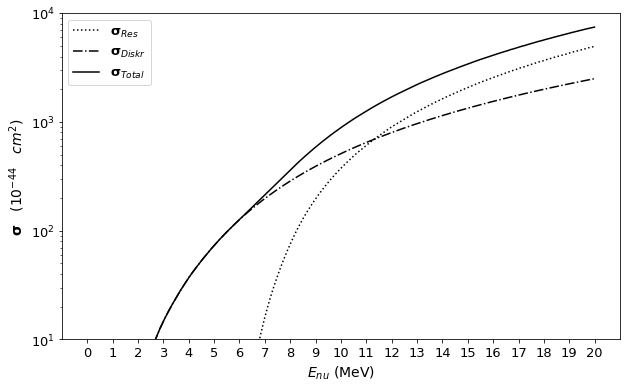

In [38]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_36_2border_full, ls=':', c='black', 
         label='$\mathbf{\sigma}_{Res}$')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='k', 
         label='$\mathbf{\sigma}_{Diskr} $')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_36_2border_full, ls='-', c='k', 
         label='$\mathbf{\sigma}_{Total} $')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(1), 10**(4))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [39]:
rate_calc(sigma_less5)

F   0.021059736624544217
pp   0.0
B   13.542307922140907
hep   0.04510635720663797
O   0.8275492449418691
N   0.10198118176409476
pep   1.3685712782859079
rate_total   15.906575720963959


In [40]:
rate_calc(sigma_36_2border_full)

F   0.0
pp   0.0
B   7.5946627950210095
hep   0.050798981185145774
O   0.0
N   0.0
pep   0.0
rate_total   7.645461776206155


In [41]:
rate_calc(sigma_less5+sigma_36_2border_full)

F   0.021059736624544217
pp   0.0
B   21.136970717161912
hep   0.09590533839178372
O   0.8275492449418691
N   0.10198118176409476
pep   1.3685712782859079
rate_total   23.552037497170115


### учет только гтр

(0, 6)

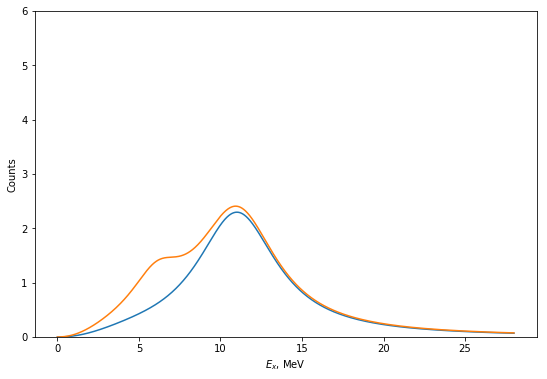

In [42]:
plt.figure(figsize=(9,6))
#plt.plot(best_fit_3pr['x'].values, best_fit_3pr['y'].values)
plt.plot(best_fit['x'].values, best_fit['GTR'].values)
plt.plot(best_fit['x'].values, best_fit['y'].values)

plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

Text(0.5,0,'Ex')

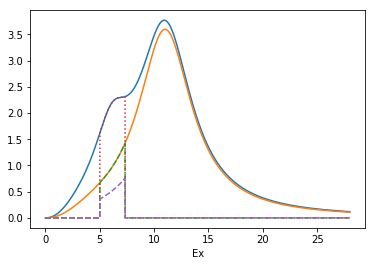

In [43]:
y_GTR_norm36 = best_fit['GTR'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (36-table_BGT)

PR_total = best_fit['PR1'].values
y_PR_norm36 = PR_total / trapz(best_fit['y'].values, best_fit['x'].values) \
* (36-table_BGT)



y_GTR_norm19 = best_fit['GTR'].values / trapz(best_fit['y'].values, best_fit['x'].values) \
* (total_GT-table_BGT)

y_PR_norm19 = PR_total / trapz(best_fit['y'].values, best_fit['x'].values) \
* (total_GT-table_BGT)


y_GTR_2border_norm36 = border_func2(best_fit['x'].values, y_GTR_norm36, 5, S_n)
y_PR_2border_norm36 = border_func2(best_fit['x'].values, y_PR_norm36, 5, S_n)

y_GTR_2border_norm19 = border_func2(best_fit['x'].values, y_GTR_norm19, 5, S_n)
y_PR_2border_norm19 = border_func2(best_fit['x'].values, y_PR_norm19, 5, S_n)

plt.plot(best_fit['x'].values, y_36)
plt.plot(best_fit['x'].values, y_GTR_norm36)
plt.plot(best_fit['x'].values, y_GTR_2border_norm36, ls='--')
plt.plot(best_fit['x'].values, y_GTR_2border_norm36+y_PR_2border_norm36, ls=':')

#plt.plot(best_fit['x'].values, y_best_fit, ls='--')
#plt.plot(best_fit['x'].values, y_GTR_norm19, ls='--')
plt.plot(best_fit['x'].values, y_GTR_2border_norm19, ls='--')
plt.xlabel('Ex')


In [44]:
#only GTR

p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_GTR_5_Sn_norm36_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                             y_GTR_2border_norm36, 200) for p in p_list]

sigma_GTR_5_Sn_norm36 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_GTR_5_Sn_norm36_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

rate_calc(sigma_GTR_5_Sn_norm36)

F   0.0
pp   0.0
B   3.437946526441378
hep   0.0234370668168955
O   0.0
N   0.0
pep   0.0
rate_total   3.4613835932582737


In [45]:
#only GTR norm 19

p_list = np.arange(0,20, 0.1) #p = z - Q

sigma_GTR_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                             y_GTR_2border_norm19, 200) for p in p_list]

sigma_GTR_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_GTR_5_Sn_norm19_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

#PR1
sigma_PR1_5_Sn_norm19_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['x'].values,
                                             y_PR_2border_norm19, 200) for p in p_list]
sigma_PR1_5_Sn_norm19 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, 
                                       fp=sigma_PR1_5_Sn_norm19_temp)

print('norm 19')
print('\n', 'GTR')
rate_calc(sigma_GTR_5_Sn_norm19)
print('\n', 'PR1')
rate_calc(sigma_PR1_5_Sn_norm19)

print('\n', 'GTR+PR1')
rate_calc(sigma_GTR_5_Sn_norm19+sigma_PR1_5_Sn_norm19)

norm 19

 GTR
F   0.0
pp   0.0
B   1.830524929594077
hep   0.012479000110946272
O   0.0
N   0.0
pep   0.0
rate_total   1.8430039297050234

 PR1
F   0.0
pp   0.0
B   2.2132318511539912
hep   0.014568774117713014
O   0.0
N   0.0
pep   0.0
rate_total   2.2278006252717044

 GTR+PR1
F   0.0
pp   0.0
B   4.043756780748069
hep   0.02704777422865929
O   0.0
N   0.0
pep   0.0
rate_total   4.070804554976728


### summ table

In [46]:
energy_bins = np.arange(0.5,5.5,0.5)
bgt_05bin=np.array([0.210,  0.068, 0.351, 0.207, 0.118, 0.255, 0.199, 0.341, 0.323, 0.360])
bgt_05bin_ind_st=np.array([ 0.163, 0.093, 0.335, 0.182, 0.035, 0.199, 0.092, 0.210, 0.154, 0.136])

In [66]:
def get_borders(right_border):
    return [right_border-0.5, right_border]

def get_bin_integral(right_border, x_data, strenght_func):
    borders = get_borders(right_border)
    y_bordered = border_func2(x_data, strenght_func, borders[0], borders[1])
    return trapz(y_bordered, x_data)

def get_bin_integral2(right_border, x_data, strenght_func):
    y_bordered = border_func(x_data, strenght_func, right_border)
    return trapz(y_bordered, x_data)

#функция для отрезки резонансов выше энергии отрыва
def border_func3(x_data, y_data, border):
    a=np.where(x_data<=border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    #print(x_data[a], y_data[a])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))

In [48]:
energy_bins

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [49]:
for elem in energy_bins:print(get_borders(elem))

[0.0, 0.5]
[0.5, 1.0]
[1.0, 1.5]
[1.5, 2.0]
[2.0, 2.5]
[2.5, 3.0]
[3.0, 3.5]
[3.5, 4.0]
[4.0, 4.5]
[4.5, 5.0]


In [50]:
bgt_05bin_integ=np.array([get_bin_integral(elem, best_fit['x'].values, y_19) for elem in 
                          energy_bins])

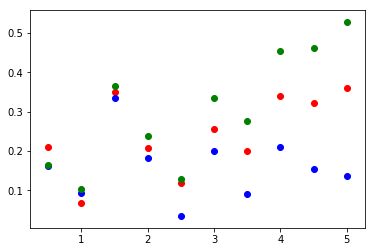

In [51]:
plt.scatter(energy_bins, bgt_05bin, c='r')
plt.scatter(energy_bins, bgt_05bin_ind_st, c='b')
plt.scatter(energy_bins, bgt_05bin_ind_st+bgt_05bin_integ, c='g')

In [53]:
borders0_right = [[0, right_border] for right_border in energy_bins]
borders0_right

[[0, 0.5],
 [0, 1.0],
 [0, 1.5],
 [0, 2.0],
 [0, 2.5],
 [0, 3.0],
 [0, 3.5],
 [0, 4.0],
 [0, 4.5],
 [0, 5.0]]

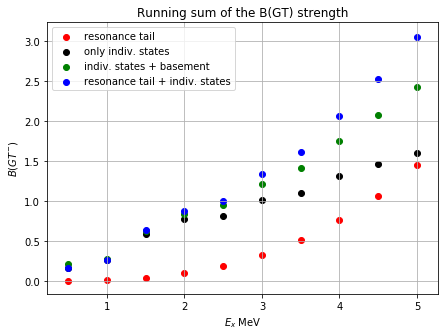

In [82]:
bgt_integ_0right=np.array([get_bin_integral2(elem, best_fit['x'].values, y_19) for elem in energy_bins])
bgt_0right = [np.sum(border_func3(energy_bins, bgt_05bin, elem)) for elem in energy_bins]
bgt_ind_0right = [np.sum(border_func3(energy_bins, bgt_05bin_ind_st, elem)) for elem in energy_bins]

plt.figure(figsize=(7,5))
plt.scatter(energy_bins, bgt_integ_0right, c='r', label = 'resonance tail')
plt.scatter(energy_bins, bgt_ind_0right, c='black', label = 'only indiv. states')
plt.scatter(energy_bins, bgt_0right, c='g', label = 'indiv. states + basement')
plt.scatter(energy_bins, bgt_integ_0right+bgt_ind_0right, c='b', label = 'resonance tail + indiv. states')
plt.xlabel('$E_{x}$ MeV')
plt.ylabel('$B(GT^{-})$')
plt.title('Running sum of the B(GT) strength')
plt.grid()
plt.legend()


In [64]:
border_func3(energy_bins, bgt_05bin_ind_st, 2)

[0.5 1.  1.5 2. ] [0.163 0.093 0.335 0.182]


array([0.163, 0.093, 0.335, 0.182, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])